<a href="https://colab.research.google.com/github/NoeGille/UNet-on-fashion-mnist/blob/main/UNet_on_fashion_MNIST_Florian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate the dataset

In [1]:
import os
import random
import numpy as np
# import matplotlib
# matplotlib.use('TkAgg') # Necessary to run matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import albumentations as A
import torch
from torchvision import transforms
from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

print(torch.__version__)
import copy

from collections import OrderedDict

from PIL import Image

from torchvision import datasets
from torchvision import transforms
import numpy as np
import random

2.0.0


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
train_dataset = datasets.FashionMNIST(root='./data', train = True, download=True)
valid_dataset = datasets.FashionMNIST(root='./data', train = False, download=True)

100%|██████████| 26421880/26421880 [00:03<00:00, 8214718.94it/s] 


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 2271465.74it/s]

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw




100%|██████████| 4422102/4422102 [00:01<00:00, 3859234.68it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [4]:
class FashionMNISTDataset(Dataset):
    def __init__(self, dataset, transform = None, 
                 shape = 224, labels = [1, 2, 3], 
                 not_labels = [5, 6, 7], background_obj = 3, 
                 include_label = True, length = 10000,
                 triangle_mode = False):
        self.dataset = dataset
        self.transform = transform
        self.shape = shape
        self.labels = labels
        self.not_labels = not_labels
        self.background_obj = background_obj
        self.include_label = include_label
        self.len = length
        self.triangle_mode = triangle_mode
    
    def random_fashion_mnist(self):
        idx = np.random.randint(0, len(self.dataset))

        img, label = self.dataset[idx]
        img = transforms.ToTensor()(img)
        return img, label
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, i):
        
        image = torch.zeros((1, self.shape, self.shape))#, dtype=torch.uint8)
        mask = torch.zeros((self.shape, self.shape))#, dtype=torch.uint8)

        x = random.randint(14, self.shape - 114)
        y = x

        points = [(x, y), (x + 100, y), (x + 100, y + 100), (x, y + 100)]

        if self.triangle_mode:
            points = random.sample(points, 3)
        
        for i in points:
            while True:
                img, label = self.random_fashion_mnist()
                if label in self.labels:
                    break
            
            x_pos, y_pos = i[0] - 14, i[1] - 14
            image[:, x_pos:x_pos+28, y_pos:y_pos+28] = img
            mask[x_pos:x_pos+28, y_pos:y_pos+28] = self.include_label * label + 1
            mask[x_pos:x_pos + 28, y_pos:y_pos + 28][img[0, :, :] == 0] = 0
        
        for i in range(self.background_obj):
            while True:
                img, label = self.random_fashion_mnist()
                if label in self.not_labels:
                    break
            while True:
                x = random.randint(0, self.shape - 28)
                y = random.randint(0, self.shape - 28)
                if (mask[x:x+28, y:y+28]).sum().item() == 0:
                    break
            image[:, x:x + 28, y:y + 28] = torch.where(image[:, x:x + 28, y:y + 28] > 0, image[:, x:x + 28, y:y + 28], img)
        
        if self.transform is not None:
            image = image.permute(1, 2, 0)
            image = np.array(image)
            mask = np.array(mask)
            transformed = self.transform(image = image, mask = mask)
            image = transformed["image"]
            mask = transformed["mask"]
            image = transforms.ToTensor()(image).to(torch.float)
            mask = torch.from_numpy(mask).long()
        return image, mask
    

In [5]:
p = 0.1
p_ = 0.2

train_transform = A.Compose(
    [
        A.HorizontalFlip(p = p),
        A.VerticalFlip(p = p),
        
        #A.geometric.rotate.Rotate(limit = 180, p = p_),
    ]
)

valid_transform = A.Compose(
    [
        
    ]
)

In [6]:
# Easy version (different labels for background and foreground)
labels = [0, 1, 2]
not_labels = [3, 4, 5]
num_background = 6
train_len = 6000
valid_len = 6000

train_data_easy = FashionMNISTDataset(dataset = train_dataset, transform = valid_transform, length = train_len, labels = labels, not_labels = not_labels, background_obj = num_background, include_label=False, triangle_mode=True)#None)#transform = train_transform)
valid_data_easy = FashionMNISTDataset(dataset = valid_dataset, transform = valid_transform, length = valid_len, labels = labels, not_labels = not_labels, background_obj = num_background, include_label=False, triangle_mode=True)#transform = None)#valid_transform)
print(len(train_data_easy), len(valid_data_easy))

# Hard version (same labels for background and foreground)
labels = [0, 1, 2]
not_labels = [0, 1, 2]
num_background = 5
train_len = 6000
valid_len = 6000

train_data_hard = FashionMNISTDataset(dataset = train_dataset, transform = valid_transform, length = train_len, labels = labels, not_labels = not_labels, background_obj = num_background)#None)#transform = train_transform)
valid_data_hard = FashionMNISTDataset(dataset = valid_dataset, transform = valid_transform, length = valid_len, labels = labels, not_labels = not_labels, background_obj = num_background)#transform = None)#valid_transform)

6000 6000


torch.Size([1, 224, 224]) torch.Size([224, 224])


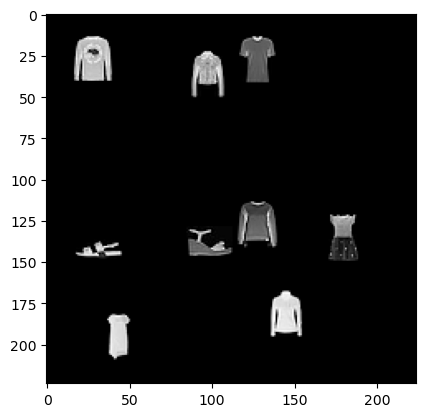

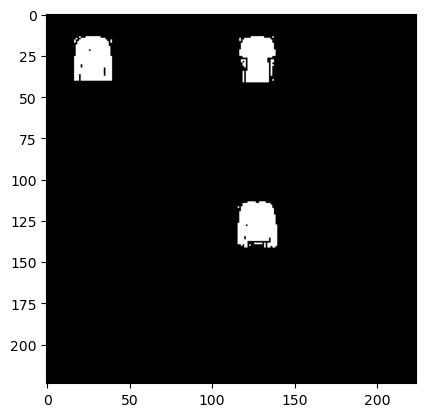

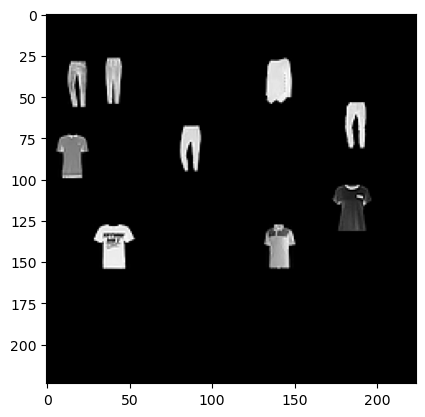

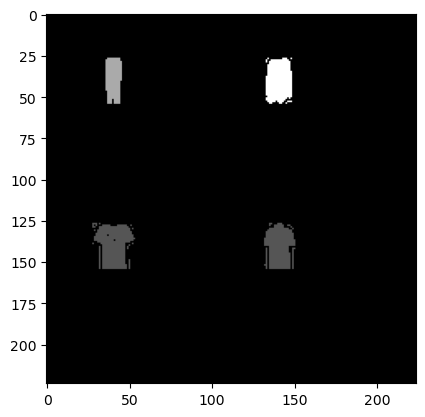

In [7]:
sample_image, sample_mask = train_data_easy[0]
print(sample_image.shape, sample_mask.shape)
sample_image_to_show = sample_image.permute(1, 2, 0)[:,:,0]
plt.figure()
plt.imshow(sample_image_to_show, cmap = 'gray')
plt.figure()
plt.imshow(sample_mask, cmap = 'gray')
plt.figure()
sample_image, sample_mask = train_data_hard[0]
sample_image_to_show = sample_image.permute(1, 2, 0)[:,:,0]
plt.imshow(sample_image_to_show, cmap = 'gray')
plt.figure()
plt.imshow(sample_mask, cmap = 'gray')
plt.show()

In [8]:
from torch.utils.data import DataLoader

NUM_CLASSES = 10
BATCH_SIZE = 16
EPOCHS = 1

train_dataloader_easy = DataLoader(train_data_easy, batch_size = BATCH_SIZE, shuffle = False)
test_dataloader_easy = DataLoader(valid_data_easy, batch_size = BATCH_SIZE, shuffle = False)

train_dataloader_hard = DataLoader(train_data_hard, batch_size = BATCH_SIZE, shuffle = False)
test_dataloader_hard = DataLoader(valid_data_hard, batch_size = BATCH_SIZE, shuffle = False)

In [9]:
# Experiments

## Different classes for foreground and background objects
## Intersecting classes for foreground and background objects

### Train shallow and deep models
### Visualize predictions once model has trained
### Evaluate using dice score
### Evaluate using precision and recall

In [10]:
class PatchEmbed(nn.Module):
    """Split image into patches and then embed them"""

    def __init__(self, img_size:int=224, patch_size:int=16, in_channels:int=1, embed_dim:int=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        # Define a conv layer to extract patches from the image
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        '''Transform the image into a tensor of patches'''
        # (n_samples, in_channels, img_size, img_size)
        x = self.proj(x) # (n_samples, embed_dim, n_patches**0.5, n_patches**0.5)
        x = x.flatten(2) # (n_samples, embed_dim, n_patches)
        x = x.transpose(1, 2)

        return x
    
class Attention(nn.Module):
    '''Attention mecanism'''

    def __init__(self, dim, n_heads, qkv_bias:bool=False, attn_p:float=0., proj_p:float=0):
        '''qkv_bias : If Ture then we include bias to the query, key adn value projections.

        attn_p : Dropout probability applied to the query, key and value tensors.
        proj_p : Dropout probability applied to the output tensor
        Note : Dropout is only applied during training, not during evaluation or prediction'''
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5
        # Input : embedding | Output : query, key and value vectors of the embedding
        # Note : We could write three seperate linear mapping that do the same thing
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        # Take the concatenates heads and map them into a new space
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)
        
    def forward(self, x):
        n_samples, n_tokens, dim = x.shape
        if dim != self.dim:
            raise ValueError
        
        qkv = self.qkv(x) # (n_samples, n_patches + 1, 3 * dim)
        qkv = qkv.reshape(
            n_samples, n_tokens, 3, self.n_heads, self.head_dim
        ) # (n_samples, n_patches + 1, 3, n_heads, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4) # (3, n_samples, n_heads, n_patches + 1, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)
        dot_product = (
            q @ k_t
        ) * self.scale # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = dot_product.softmax(dim=-1) # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = self.attn_drop(attn)
        weighted_avg = attn @ v # (n_samples, n_heads, n_patches + 1, head_dim)
        # Flatten last 2 dimension <=> Concatenate each head output
        weighted_avg = weighted_avg.transpose(1, 2) # (n_samples, n_patches + 1, n_heads, head_dim)
        # head_dim = dim // n_heads => Get the same dimesion as input
        weighted_avg = weighted_avg.flatten(2) # (n_samples, n_patches + 1, dim)
        # Final linear projection and dropout
        x = self.proj(weighted_avg) # (n_samples, n_patches + 1, dim)
        x = self.proj_drop(x) # (n_samples, n_patches + 1, dim)

        return x
    
class MLP(nn.Module):
    '''MultiLayer Perception'''
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        '''One hidden layer'''
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        return self.dropout(self.fc2(self.dropout(self.activation(self.fc1(x)))))


class Block(nn.Module):

    def __init__(self, dim, n_heads, mlp_ratio, qkv_bias, p, attn_p):
        '''mlp_ratio : determine the hidden dimension size of the mlp module with respect to dim'''
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(dim, n_heads, qkv_bias, attn_p, proj_p=p)
        self.mlp = MLP(
            in_features=dim, 
            hidden_features=int(dim * mlp_ratio), 
            out_features=dim
        )
    
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [15]:
LEARNING_RATE = 0.0001
INPUT_SIZE = (224, 224, 1)

# A faire : ajouter des batch normalization si problème de valeur extremes en sorties


class DownSampleBlock(nn.Module):
    '''Reduce the dimension of the image in input by 2'''
    def __init__(self, in_channels, out_channels):
        super(DownSampleBlock, self).__init__()
        # We keep the same dimension in input and ouput
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                               kernel_size=(3, 3), stride=(1, 1), padding=(1,1))
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                               kernel_size=(3, 3), stride=(1, 1), padding=(1,1))
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2,2))

    def forward(self, x):
        x = self.norm2(self.conv2(self.relu(self.norm1(self.conv1(x)))))
        return self.pool(x), x

class DoubleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConvolution, self).__init__()
        # We keep the same dimension in input and ouput
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                               kernel_size=(3, 3), stride=(1, 1), padding=(1,1))
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                               kernel_size=(3, 3), stride=(1, 1), padding=(1,1))
        self.norm2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
      x = self.relu(self.norm2(self.conv2(self.relu(self.norm1(self.conv1(x))))))
      return x

class UpSampleBlock(nn.Module):
    '''Increase the dimension of the input and reduce its number of channels by 2'''
    def __init__(self, in_channels, out_channels):
        super(UpSampleBlock, self).__init__()
        self.up1 = nn.ConvTranspose2d(in_channels, out_channels, 2, 2)
        self.conv1 = nn.Conv2d(in_channels=out_channels,
                                     out_channels=out_channels, kernel_size=(3, 3),
                                     stride=(1, 1), padding=(1,1))
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.bn(self.conv1(self.up1(x))))
        return x

class ResidualConnection(nn.Module):
    '''Concatenate inputs of two blocs'''

    def __init__(self, in_channels, out_channels):
        '''in_channels has the same dimensions as out_channels'''

        super(ResidualConnection, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels * 2, out_channels=in_channels,
                               kernel_size=(3, 3), stride=(1, 1), padding=(1,1))
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                               kernel_size=(3, 3), stride=(1, 1), padding=(1,1))
        self.norm2 = nn.BatchNorm2d(out_channels)

    def forward(self, x1, x2):
        x = torch.cat([x2, x1], dim=1)
        x = self.relu(self.norm2(self.conv2(self.relu(self.norm1(self.conv1(x))))))
        return x

class UNETR(nn.Module):
    '''UNETR model for 2D images'''
    def __init__(self, img_size=224, patch_size=16, in_chans=1, num_classes=10, 
                 embed_dim=768, depth=12, n_heads=4, mlp_ratio=4., qkv_bias=True, p=0., attn_p=0.):
        super(UNETR, self).__init__()
        # Encoder
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_channels=in_chans,embed_dim=embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=p)
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p
                )
                for _ in range(depth)
            ]
        )
        # TODO : Add residual connection
        
        
        # Decoder (uses deconv layers)
        # dim : 
        #   - input (768, W/16, H/16)
        #   - output (num_classes, W, H)
        self.up1 = nn.ConvTranspose2d(in_channels=embed_dim, out_channels=512, kernel_size=2, stride=2) # (512, W/8, H/8)
        self.residual1 = ResidualConnection(in_channels=512, out_channels=512)
        self.up2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2) # (256, W/4, H/4
        self.residual2 = ResidualConnection(in_channels=256, out_channels=256)
        self.up3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2) # (128, W/2, H/2)
        self.residual3 = ResidualConnection(in_channels=128, out_channels=128)
        self.up4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2) # (64, W, H)
        self.residual4 = ResidualConnection(in_channels=64, out_channels=64)
        # Note : these values are hardcoded for now and follow the paper of UNETR

        # Changing encoder output to match decoder input at each step of decoding
        self.z9 = nn.ModuleList(
            [UpSampleBlock(in_channels=768, out_channels=512)]
        )
        self.z6 = nn.ModuleList(
            [UpSampleBlock(in_channels=768, out_channels=512),
             UpSampleBlock(in_channels=512, out_channels=256)]
        )
        self.z3 = nn.ModuleList(
            [UpSampleBlock(in_channels=768, out_channels=512),
             UpSampleBlock(in_channels=512, out_channels=256),
             UpSampleBlock(in_channels=256, out_channels=128)]
        )
        self.double_conv1 = DoubleConvolution(in_channels=4, out_channels=64)
        self.double_conv2 = DoubleConvolution(in_channels=64, out_channels=64)
        self.conv = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):

        inputs = x
        # Encoder

        # Transform input images into patch embedding
        n_samples = x.shape[0]
        x = self.patch_embed(x)
        # Replicates the class token over the sample dimension
        cls_token = self.cls_token.expand(n_samples, -1, -1) # (n_samples, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1) # (n_samples, 1 + n_patches, embed_dim)
        x = x + self.pos_embed # (n_samples, 1 + n_patches, embed_dim)
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)
        encoder_output = x

        # Decoder
        x = self.up1(x)
        x = self.residual1(self.z9(encoder_output), x)
        x = self.up2(x)
        x = self.residual2(self.z6(encoder_output), x)
        x = self.up3(x)
        x = self.residual3(self.z3(encoder_output), x)
        x = self.up4(x)
        x = self.residual4(self.double_conv1(inputs), x)
        x = self.double_conv2(x)
        x = self.conv(x)
        
        return x



In [16]:
model = UNETR(in_chans=1, num_classes=NUM_CLASSES).to(device=DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

TypeError: unsupported operand type(s) for //: 'tuple' and 'int'

In [ ]:
# Import confision matrix, accuracy, precision, recall, f1 score and dice score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, jaccard_score  

class SegmentationMetrics():
    '''class that prodives a way to compute, save and plot metrics for semantic segmentation tasks
    List of available metrics : "accuracy", "dice_score", "precision", "recall"'''
    def __init__(self) -> None:
        self.metrics = {"accuracy":[],
          "dice_score":[],
          "precision":[],
          "recall":[]}
        self.acc = 0
        self.precision = 0
        self.recall = 0
        self.dice_score = 0


    def add(self, y_true, y_pred):
        '''Compute from y_true and y_pred the metrics and save them at the end of the dictionary'''
        # Compute confusion matrix values
        TP = (y_pred == y_true).sum()
        TN = ((y_pred == 0) & (y_true == 0)).sum()
        FP = ((y_pred != 0) & (y_true == 0)).sum()
        FN = ((y_pred == 0) & (y_true != 0)).sum()

        # Compute metrics
        acc = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        dice_score = 2 * TP / (2 * TP + FP + FN)
        
        # Save metrics for plotting in a dictionary
        self.metrics["accuracy"].append(np.round(acc.cpu().numpy(), decimals=4))
        self.metrics["precision"].append(np.round(precision.cpu().numpy(), decimals=4))
        self.metrics["recall"].append(np.round(recall.cpu().numpy(), decimals=4))
        self.metrics["dice_score"].append(np.round(dice_score.cpu().numpy(), decimals=4))


    def plot(self):
        '''Plot the metrics saved in the dictionary during training'''
        plt.plot(torch.Tensor(self.metrics["accuracy"]).cpu().numpy(), label="accuracy")
        plt.plot(torch.Tensor(self.metrics["dice_score"]).cpu().numpy(), label="dice_score")
        plt.plot(torch.Tensor(self.metrics["precision"]).cpu().numpy(), label="precision")
        plt.plot(torch.Tensor(self.metrics["recall"]).cpu().numpy(), label="recall")
        plt.legend()

    def reset(self):
        '''Reset the dictionary'''
        self.metrics = {"accuracy":[],
          "dice_score":[],
          "precision":[],
          "recall":[]}

metrics = SegmentationMetrics()

for epoch in range(EPOCHS):
    #metrics_calculator = SegmentationMetrics()
    i = 0
    for img, mask in tqdm(train_dataloader_easy):
        
        img = img.to(device=DEVICE)
        mask = mask.to(device=DEVICE) # dim : (batch_size, 224, 224)
        # prediction
        mask_pred = model(img)  # dim : (batch_size, 10, 224, 224)
        # Calculate loss
        loss = criterion(mask_pred, mask)
        
        # Save data on training for plotting
        if i % 3 == 0 and i != 0:
            predictions = mask_pred.argmax(1)
            metrics.add(mask, predictions)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        i += 1
    

100%|██████████| 375/375 [00:38<00:00,  9.78it/s]


{'accuracy': [0.9497, 0.9527, 0.957, 0.9605, 0.9605, 0.9634, 0.9643, 0.9656, 0.9663, 0.9652, 0.967, 0.9652, 0.9656, 0.9644, 0.9649, 0.9664, 0.9657, 0.9655, 0.9661, 0.9662, 0.9665, 0.9671, 0.9686, 0.9686, 0.9688, 0.9705, 0.9702, 0.9719, 0.9719, 0.9691, 0.9684, 0.9712, 0.968, 0.9723, 0.9704, 0.9718, 0.9732, 0.9748, 0.9748, 0.9744, 0.974, 0.9737, 0.9733, 0.9729, 0.9744, 0.9732, 0.9738, 0.9726, 0.9732, 0.9765, 0.9741, 0.972, 0.9728, 0.9746, 0.9763, 0.9746, 0.9746, 0.9755, 0.9733, 0.9729, 0.9749, 0.973, 0.9747, 0.9754, 0.9742, 0.9762, 0.9769, 0.9767, 0.9771, 0.9767, 0.9762, 0.9752, 0.9762, 0.9767, 0.9741, 0.9792, 0.9767, 0.9781, 0.9771, 0.9773, 0.9788, 0.9784, 0.9802, 0.9789, 0.9791, 0.9769, 0.9785, 0.9812, 0.9806, 0.9822, 0.9804, 0.9816, 0.9795, 0.9815, 0.9825, 0.9827, 0.9804, 0.9819, 0.9813, 0.9833, 0.9829, 0.9824, 0.9842, 0.9851, 0.9816, 0.9814, 0.9835, 0.9845, 0.9836, 0.9798, 0.9843, 0.9827, 0.9836, 0.9832, 0.9843, 0.985, 0.9841, 0.9821, 0.9864, 0.9851, 0.9855, 0.9824, 0.9836, 0.9887], 

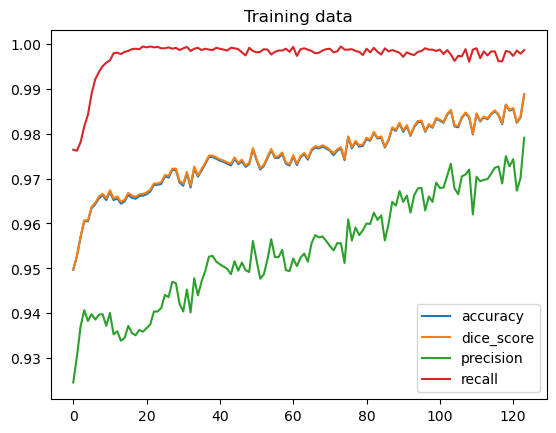

In [ ]:
metrics.plot()
print(metrics.metrics)
plt.title("Training data")
plt.show()


torch.Size([1, 224, 224]) torch.Size([224, 224])
torch.Size([1, 2, 224, 224])


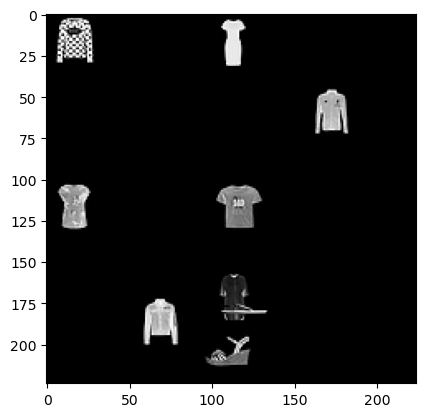

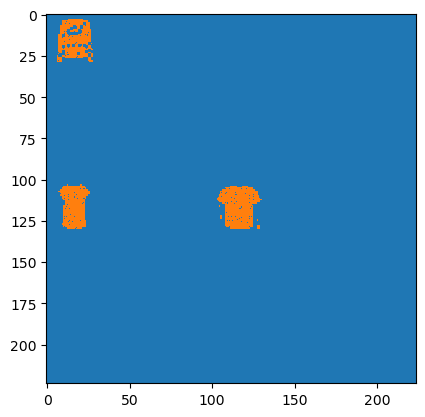

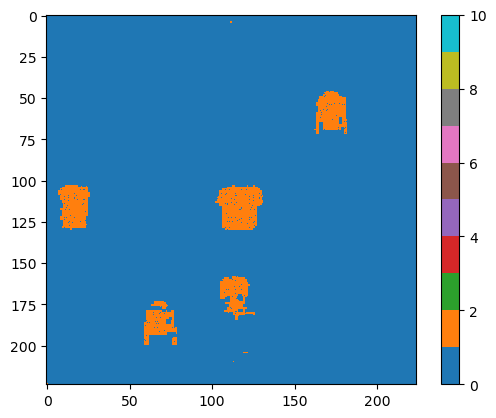

{'accuracy': [0.9787], 'dice_score': [0.9789], 'precision': [0.9677], 'recall': [0.9904]}


In [ ]:
sample_image, sample_mask = valid_data_easy[0]
print(sample_image.shape, sample_mask.shape)
sample_image_to_show = sample_image.permute(1, 2, 0)[:,:,0]
plt.figure()
plt.imshow(sample_image_to_show, cmap = 'gray')
plt.figure()
plt.imshow(sample_mask, vmin=0, vmax=10, cmap='tab10')
fig = plt.figure()
with torch.no_grad():
    metrics = SegmentationMetrics()
    prediction = model(torch.from_numpy(np.array([sample_image.numpy()])).to(device=DEVICE))
    print(prediction.shape)
    metrics.add(sample_mask, prediction.argmax(1).to(device='cpu'))
    plt.imshow(prediction.argmax(1).cpu().numpy()[0], vmin=0, vmax=10, cmap='tab10')
    plt.colorbar()
plt.show()
print(metrics.metrics)

In [ ]:
def train(model, loader):
    '''Train a model on the data contained on loader'''
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    for epoch in range(EPOCHS):
        for img, mask in tqdm(loader):

            img = img.to(device=DEVICE)
            mask = mask.to(device=DEVICE) # dim : (batch_size, 224, 224)
            # prediction
            mask_pred = model(img)  # dim : (batch_size, 10, 224, 224)
            
            # Calculate loss
            loss = criterion(mask_pred, mask)
            # backward
            optimizer.zero_grad()
            loss.backward()
            
            #gradient descent or adam step
            optimizer.step()
    return metrics.metrics

# Training four models with differents depths
model1 = UNet(INPUT_SIZE, num_classes=NUM_CLASSES, depth=1).to(device=DEVICE)
model2 = UNet(INPUT_SIZE, num_classes=NUM_CLASSES, depth=2).to(device=DEVICE)
model3 = UNet(INPUT_SIZE, num_classes=NUM_CLASSES, depth=3).to(device=DEVICE)
model4 = UNet(INPUT_SIZE, num_classes=NUM_CLASSES, depth=4).to(device=DEVICE)

train(model1, train_dataloader_easy)
train(model2, train_dataloader_easy)
train(model3, train_dataloader_easy)
train(model4, train_dataloader_easy)

100%|██████████| 375/375 [00:35<00:00, 10.59it/s]


{'accuracy': [0.9787],
 'dice_score': [0.9789],
 'precision': [0.9677],
 'recall': [0.9904]}

torch.Size([1, 224, 224]) torch.Size([224, 224])


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


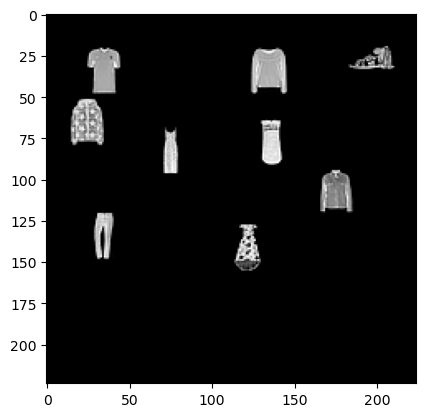

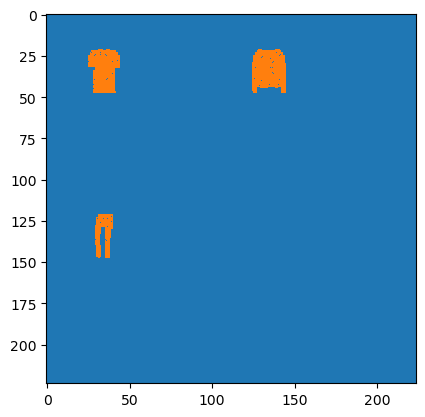

<Figure size 2500x1500 with 0 Axes>

In [ ]:
sample_image, sample_mask = train_data_easy[0]
print(sample_image.shape, sample_mask.shape)
sample_image_to_show = sample_image.permute(1, 2, 0)[:,:,0]
plt.figure()
plt.imshow(sample_image_to_show, cmap = 'gray')
plt.figure()
plt.imshow(sample_mask, vmin=0, vmax=10, cmap='tab10')
fig = plt.figure(figsize=(25,15))
with torch.no_grad():
    for i, model in enumerate([model1, model2, model3, model4]):
        prediction = model(torch.from_numpy(np.array([sample_image.numpy()])).to(device=DEVICE))
        fig.add_subplot(1, 4,i + 1)
        plt.title(f"depth = {i + 1}")
        plt.imshow(prediction.argmax(1).cpu().numpy()[0], vmin=0, vmax=10, cmap='tab10')
    plt.colorbar()
plt.show()

In [ ]:
# Training four models with differents depths
model5 = UNet(INPUT_SIZE, num_classes=NUM_CLASSES, depth=1).to(device=DEVICE)
model6 = UNet(INPUT_SIZE, num_classes=NUM_CLASSES, depth=2).to(device=DEVICE)
model7 = UNet(INPUT_SIZE, num_classes=NUM_CLASSES, depth=3).to(device=DEVICE)
model8 = UNet(INPUT_SIZE, num_classes=NUM_CLASSES, depth=4).to(device=DEVICE)

train(model5, train_dataloader_hard)
train(model6, train_dataloader_hard)
train(model7, train_dataloader_hard)
train(model8, train_dataloader_hard)

  0%|          | 1/375 [00:00<03:23,  1.84it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


torch.Size([1, 224, 224]) torch.Size([224, 224])


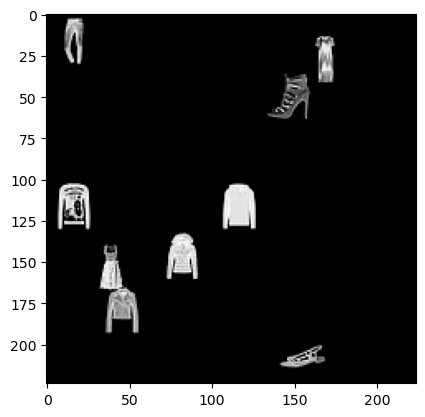

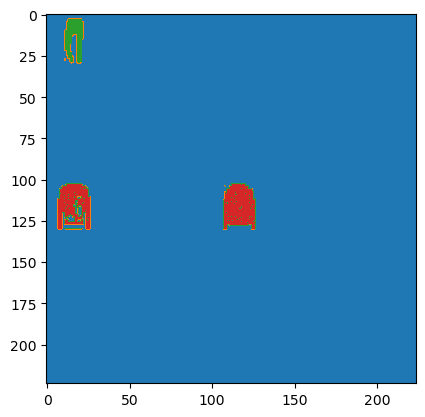

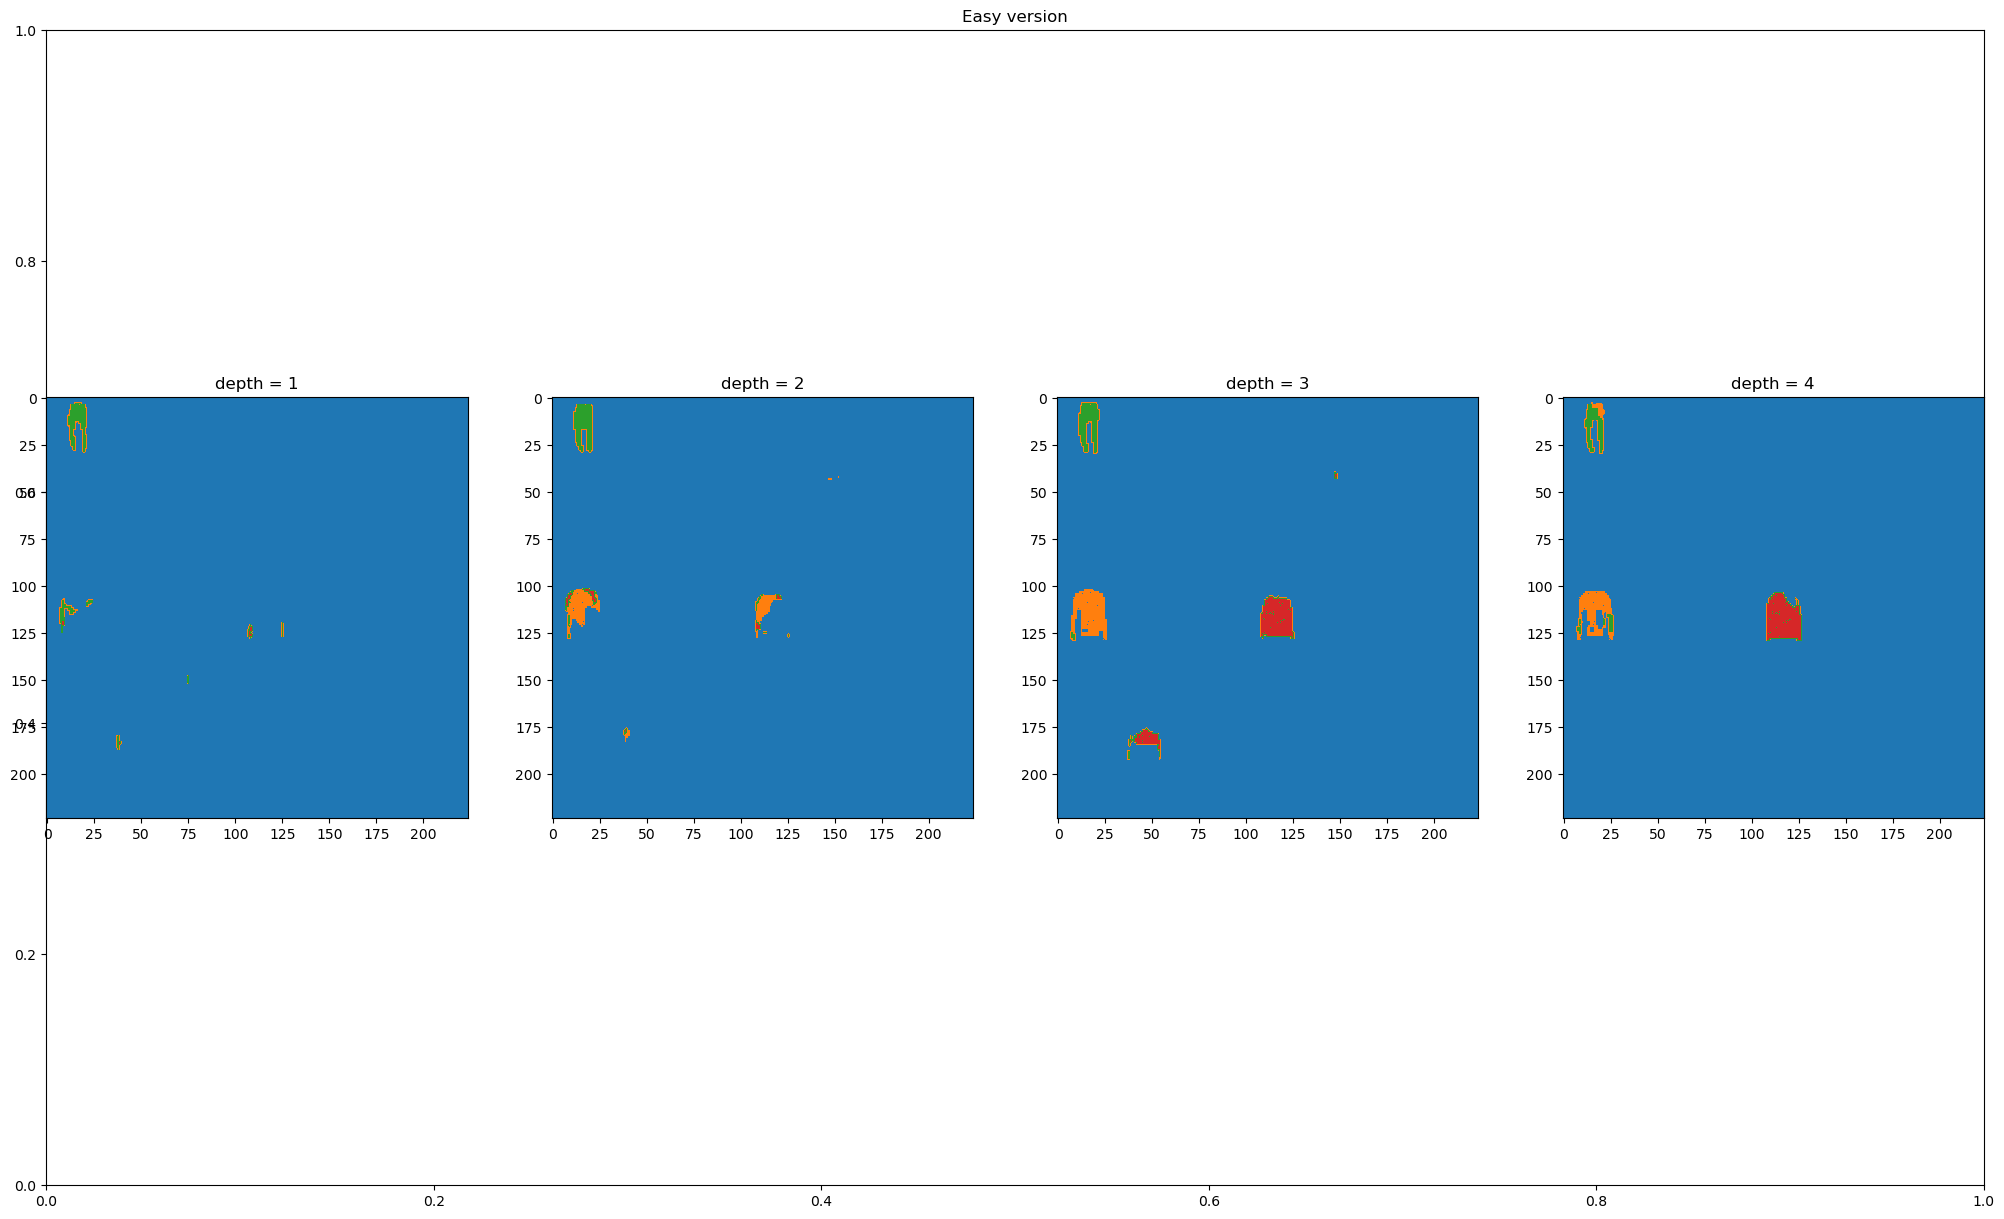

torch.Size([1, 224, 224]) torch.Size([224, 224])


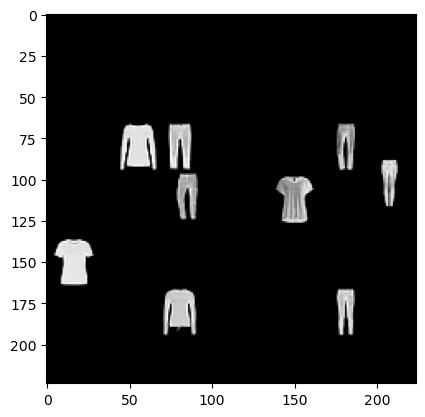

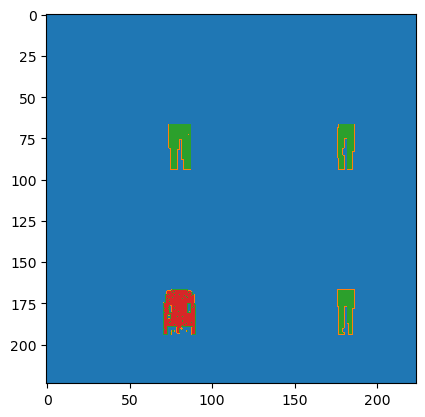

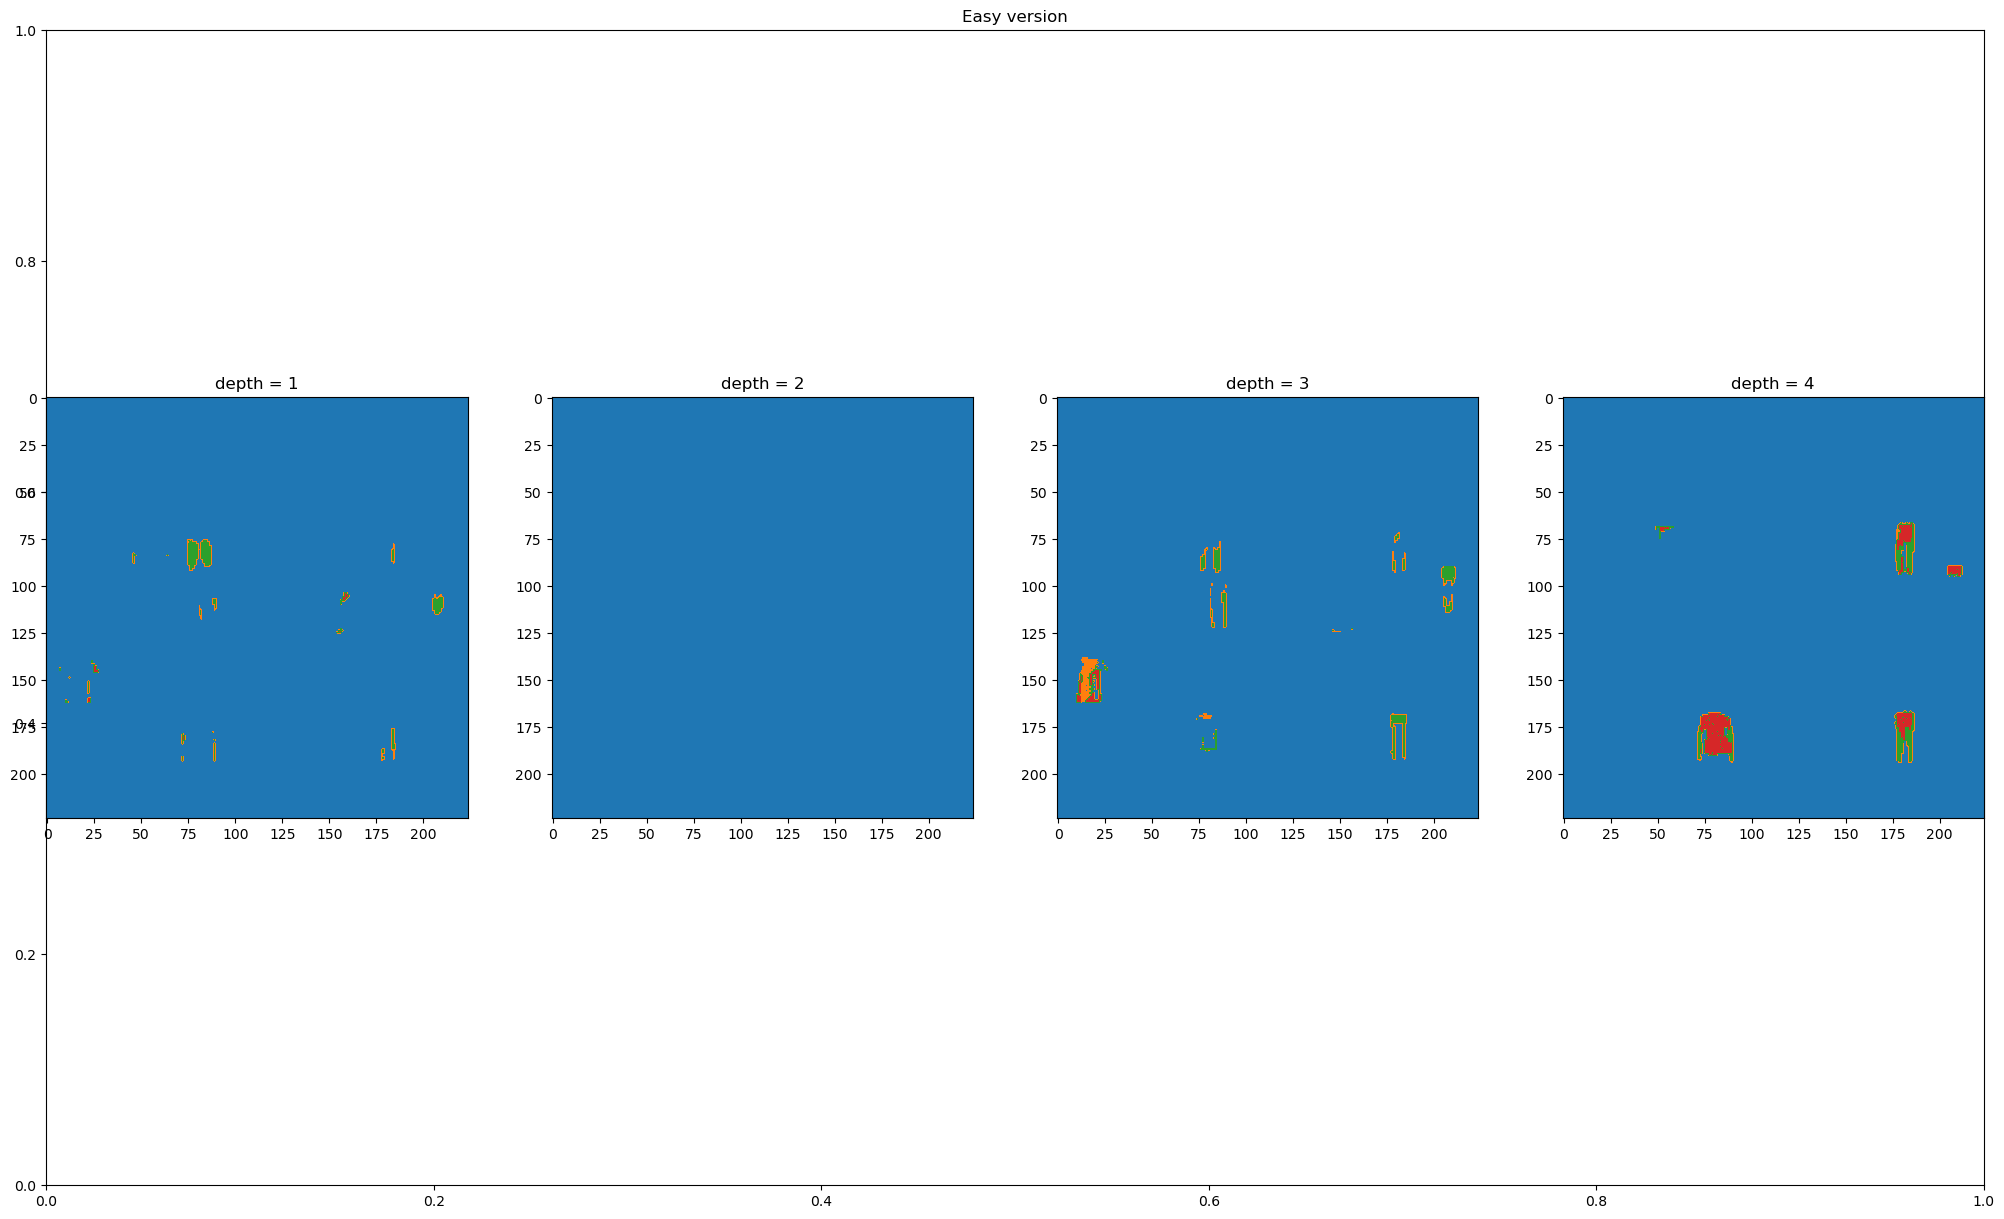

In [ ]:
sample_image, sample_mask = train_data_easy[0]
print(sample_image.shape, sample_mask.shape)
sample_image_to_show = sample_image.permute(1, 2, 0)[:,:,0]
plt.figure()
plt.imshow(sample_image_to_show, cmap = 'gray')
plt.figure()
plt.imshow(sample_mask, vmin=0, vmax=10, cmap='tab10')
fig = plt.figure(figsize=(25,15))
plt.title("Easy version")
with torch.no_grad():
    for i, model in enumerate([model1, model2, model3, model4]):
        prediction = model(torch.from_numpy(np.array([sample_image.numpy()])).to(device=DEVICE))
        fig.add_subplot(1, 4,i + 1)
        plt.title(f"depth = {i + 1}")
        plt.imshow(prediction.argmax(1).cpu().numpy()[0], vmin=0, vmax=10, cmap='tab10')
plt.show()

sample_image, sample_mask = train_data_hard[0]
print(sample_image.shape, sample_mask.shape)
sample_image_to_show = sample_image.permute(1, 2, 0)[:,:,0]
plt.figure()
plt.imshow(sample_image_to_show, cmap = 'gray')
plt.figure()
plt.imshow(sample_mask, vmin=0, vmax=10, cmap='tab10')
fig = plt.figure(figsize=(25,15))
plt.title("Easy version")
with torch.no_grad():
    for i, model in enumerate([model5, model6, model7, model8]):
        prediction = model(torch.from_numpy(np.array([sample_image.numpy()])).to(device=DEVICE))
        fig.add_subplot(1, 4,i + 1)
        plt.title(f"depth = {i + 1}")
        plt.imshow(prediction.argmax(1).cpu().numpy()[0], vmin=0, vmax=10, cmap='tab10')
plt.show()

## Atrous UNet

In [ ]:
LEARNING_RATE = 0.01
INPUT_SIZE = (224, 224, 1)

# A faire : ajouter des batch normalization si problème de valeur extremes en sorties


class DownSampleBlock(nn.Module):
    '''Reduce the dimension of the image in input by 2'''
    def __init__(self, in_channels, out_channels):
        super(DownSampleBlock, self).__init__()
        # We keep the same dimension in input and ouput
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                               kernel_size=(3, 3), stride=(1, 1), padding=(2,2), dilation=(2, 2))
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                               kernel_size=(3, 3), stride=(1, 1), padding=(2,2), dilation=(2, 2))
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2,2))

    def forward(self, x):
        x = self.norm2(self.conv2(self.relu(self.norm1(self.conv1(x)))))
        return self.pool(x), x

class DoubleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConvolution, self).__init__()
        # We keep the same dimension in input and ouput
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                               kernel_size=(3, 3), stride=(1, 1), padding=(1,1))
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                               kernel_size=(3, 3), stride=(1, 1), padding=(1,1))
        self.norm2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
      x = self.norm2(self.conv2(self.relu(self.norm1(self.conv1(x)))))
      return x

class UpSampleBlock(nn.Module):
    '''Increase the dimension of the input and reduce its number of channels by 2'''
    def __init__(self, in_channels):
        super(UpSampleBlock, self).__init__()
        self.up1 = nn.ConvTranspose2d(in_channels, in_channels, 2, 2)
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=in_channels, kernel_size=(3, 3),
                                     stride=(1, 1), padding=(1,1))
        
    def forward(self, x):
        x = self.conv1(self.up1(x))
        return x

class ResidualConnection(nn.Module):
    '''Concatenate inputs of two blocs'''

    def __init__(self, in_channels, out_channels):
        '''in_channels has the same dimensions as out_channels'''

        super(ResidualConnection, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels * 2, out_channels=in_channels,
                               kernel_size=(3, 3), stride=(1, 1), padding=(1,1))
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                               kernel_size=(3, 3), stride=(1, 1), padding=(1,1))
        self.norm2 = nn.BatchNorm2d(out_channels)

    def forward(self, x1, x2):
        x = torch.cat([x2, x1], dim=1)
        x = self.norm2(self.conv2(self.relu(self.norm1(self.conv1(x)))))
        return x

class AtrousUNet(nn.Module):

    # Numbers of filters for the first layer of convolution
    # <!> The number of filters will double for each down sample blocks which can
    # lead to very high numbers of parameters very quickly <!>
    NB_OF_FILTERS = 16

    def __init__(self, input_size, num_classes:int=10, depth:int=2):
        '''### Initialize a UNet model
        input_size : dimension of input
        num_classes : specify the number of classes in ouput
        depth : the number of blocks (depth of the model)'''
        super(AtrousUNet, self).__init__()
        channels = [input_size[-1]] + [self.NB_OF_FILTERS * (i + 1) for i in range(depth)]
        # first downsampling block
        self.dblocks = nn.ModuleList([DownSampleBlock(in_channels=channels[0], out_channels=channels[1])])
        self.bottleneck = DoubleConvolution(in_channels=channels[-1], out_channels=channels[-1])
        # Concatenate outputs from encoder and decoder to keep tracks of objects positions
        self.res_connect = nn.ModuleList([ResidualConnection(in_channels=channels[1], out_channels=num_classes)])
        # Last upsampling block
        self.ublocks = nn.ModuleList([UpSampleBlock(in_channels=channels[1])])

        for i in range(1,depth):
            # The number of channels double each time the depth increases
            self.dblocks.append(DownSampleBlock(in_channels=channels[i], out_channels=channels[i + 1]))
            self.res_connect.append(ResidualConnection(in_channels=channels[i + 1], out_channels=channels[i]))
            self.ublocks.append(UpSampleBlock(in_channels=channels[i + 1]))
        self.ublocks = self.ublocks[::-1]
        self.res_connect = self.res_connect[::-1]
        self.output = nn.Conv2d(in_channels=num_classes, out_channels=num_classes,
                               kernel_size=(3, 3), stride=(1, 1), padding=(1,1))

    def forward(self, x):
        depth = len(self.dblocks)

        # Encoder
        # Copy of output of each blocks before downsampling
        xs_down =[]
        for i, down_block in enumerate(self.dblocks):
            x, copy = down_block.forward(x)
            xs_down.append(copy)
        x = self.bottleneck.forward(x)
        xs_down = xs_down[::-1]
        # Decoder
        for i, up_block in enumerate(self.ublocks):
            x_up = up_block.forward(x)
            x = self.res_connect[i](x_up, xs_down[i])
        
        x = self.output(x)
        
        return x


model9 = AtrousUNet(input_size=INPUT_SIZE, num_classes=NUM_CLASSES, depth=1).to(device=DEVICE)
model10 = AtrousUNet(input_size=INPUT_SIZE, num_classes=NUM_CLASSES, depth=2).to(device=DEVICE)
model11 = AtrousUNet(input_size=INPUT_SIZE, num_classes=NUM_CLASSES, depth=3).to(device=DEVICE)
model12 = AtrousUNet(input_size=INPUT_SIZE, num_classes=NUM_CLASSES, depth=4).to(device=DEVICE)

train(model9, train_dataloader_easy)
train(model10, train_dataloader_easy)
train(model11, train_dataloader_easy)
train(model12, train_dataloader_easy)

100%|██████████| 375/375 [00:38<00:00,  9.83it/s]


{'accuracy': [0.9859],
 'dice_score': [0.986],
 'precision': [0.9932],
 'recall': [0.979]}

torch.Size([1, 224, 224]) torch.Size([224, 224])


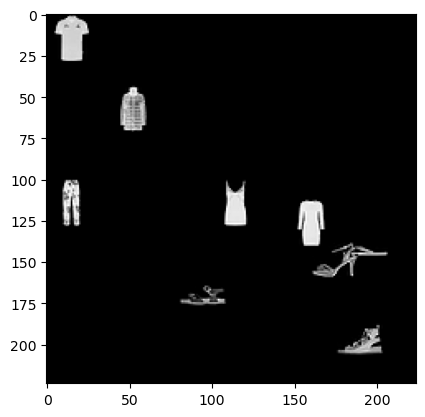

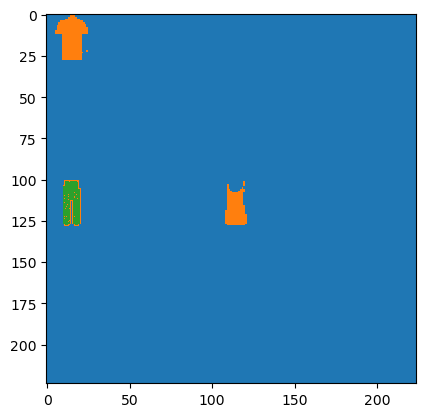

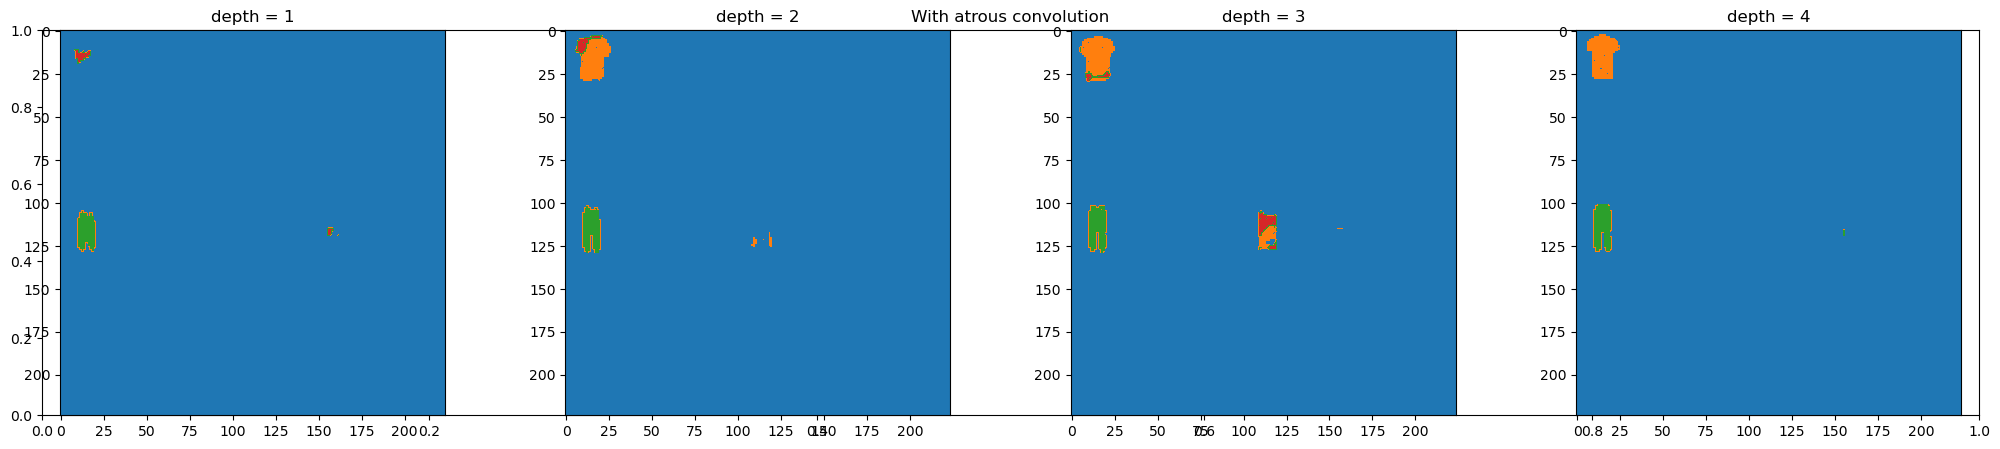

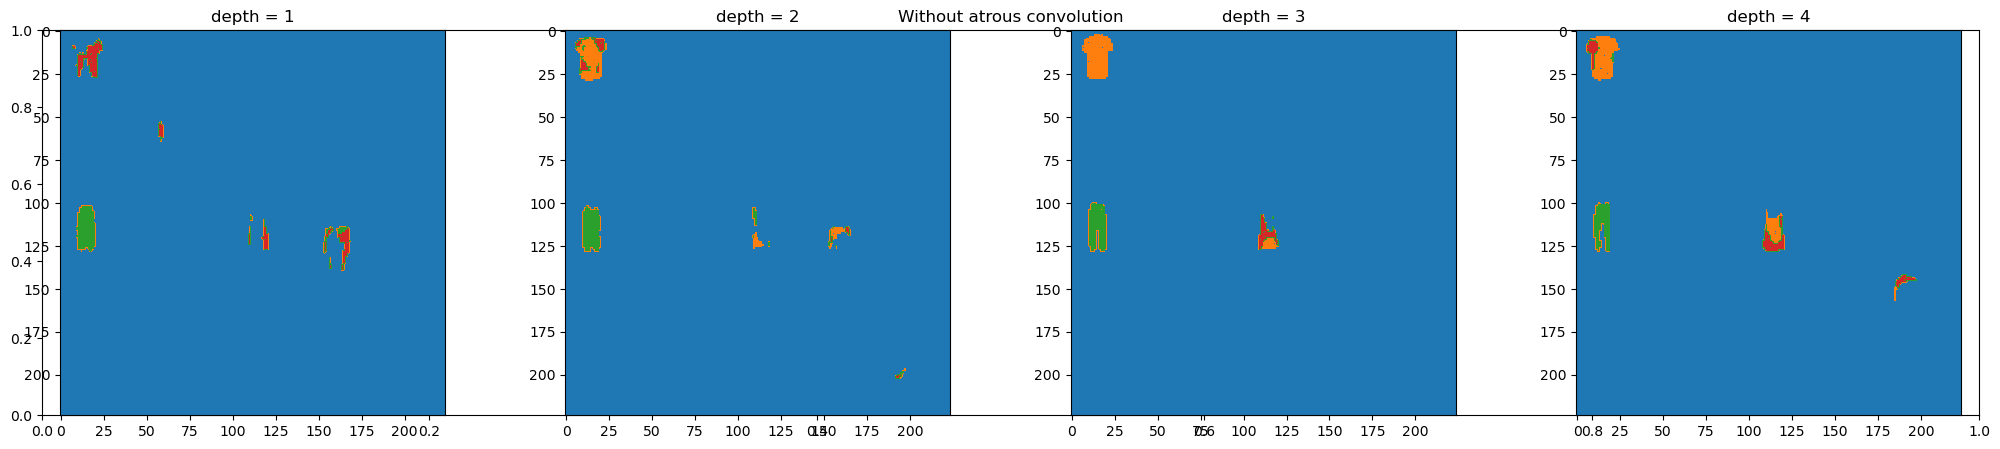

In [ ]:
sample_image, sample_mask = train_data_easy[0]
print(sample_image.shape, sample_mask.shape)
sample_image_to_show = sample_image.permute(1, 2, 0)[:,:,0]
plt.figure()
plt.imshow(sample_image_to_show, cmap = 'gray')
plt.figure()
plt.imshow(sample_mask, vmin=0, vmax=10, cmap='tab10')
fig = plt.figure(figsize=(25,5))
plt.title("With atrous convolution")
with torch.no_grad():
    for i, model in enumerate([model9, model10, model11, model12]):
        prediction = model(torch.from_numpy(np.array([sample_image.numpy()])).to(device=DEVICE))
        fig.add_subplot(1, 4,i + 1)
        plt.title(f"depth = {i + 1}")
        plt.imshow(prediction.argmax(1).cpu().numpy()[0], vmin=0, vmax=10, cmap='tab10')
plt.show()
fig = plt.figure(figsize=(25,5))
plt.title("Without atrous convolution")
with torch.no_grad():
    for i, model in enumerate([model1, model2, model3, model4]):
        prediction = model(torch.from_numpy(np.array([sample_image.numpy()])).to(device=DEVICE))
        fig.add_subplot(1, 4,i + 1)
        plt.title(f"depth = {i + 1}")
        plt.imshow(prediction.argmax(1).cpu().numpy()[0], vmin=0, vmax=10, cmap='tab10')
plt.show()